# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [6]:
# from google.colab import drive

# drive.mount("/gdrive")
# %cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

## ⚙️ Import Libraries

In [7]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data

In [8]:
data = np.load("/kaggle/input/mars-for-students/mars_for_students.npz")
# data = np.load("mars_cleaned_and_augmented.npz")

#X_train = data['X_train']
#y_train = data['y_train']

#X_test = data["X_test"]

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

# find the number of occurences similar to the image at index 348 in the training set
# Compare all the image in y_train with the image at index 348, if they are equal, add the index to a list and increment a counter
index = 348
similar_images = []
for i, image in enumerate(y_train):
    if np.array_equal(image, y_train[index]):
        similar_images.append(i)
        
print(f"Number of similar images: {len(similar_images)}")

# Remove all the corrupted data in y_train and X_train and register a new dataset 
X_train = np.delete(X_train, similar_images, axis=0)
y_train = np.delete(y_train, similar_images, axis=0)

X_train = tf.clip_by_value(X_train[..., np.newaxis] / 255.0 * 1.5, 0.0, 1.0)
y_train = y_train[..., np.newaxis]
X_test  = tf.clip_by_value(X_test[..., np.newaxis] / 255.0 * 1.5, 0.0, 1.0)

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Number of similar images: 110
Training X shape: (2505, 64, 128, 1)
Training y shape: (2505, 64, 128, 1)
Test X shape: (10022, 64, 128, 1)


## Prepare the data


In [9]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [10]:
LEARNING_RATE = 5e-3
EPOCHS = 1000
PATIENCE = 30
BATCH_SIZE = 64 
SPLITS_SIZE = 300
SEED = 42
NUM_CLASSES = 5

X_train = X_train.numpy() if isinstance(X_train, tf.Tensor) else np.array(X_train)
y_train = y_train.numpy() if isinstance(y_train, tf.Tensor) else np.array(y_train)

from sklearn.model_selection import train_test_split

#train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
#    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
#)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)


print(f"Train set shape: {train_img.shape}")
print(f"Validation image set shape: {val_img.shape}")
print(f"Validation masks set shape: {val_lbl.shape}")
# print(f"Test set shape: {test_img.shape}")




Train set shape: (2205, 64, 128, 1)
Validation image set shape: (300, 64, 128, 1)
Validation masks set shape: (300, 64, 128, 1)


## Augmentation

In [11]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print(image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label

from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    # dataset = dataset.map(
    #     lambda x, y: (x, apply_category_mapping(y)),
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    if augment:

        augmentations = A.Compose([
            #A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Flip(),
            # A.Transpose(),
            #A.GaussNoise(),
            A.OneOf([
                A.MotionBlur(p=.2),
                #A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=.1),
            ], p=0.2),
            A.RandomGridShuffle(grid = (3,3), always_apply=False, p = 0.3),
            A.RandomBrightnessContrast(brightness_limit = 0.2,
                                        contrast_limit = 0.2,
                                        always_apply = False,
                                        p = 0.2
                                      ),
            #A.Sharpen(alpha=(0.2, 0.5), lightness = (0.5, 1.0), always_apply=False, p = 0.5),
            A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
            # A.RandomCrop(height=64, width=128, p=1),
            # A.OneOf([
            #     #A.CLAHE(clip_limit=2),
            #     A.RandomBrightnessContrast(),
            # ], p=0.3),
            # A.HueSaturationValue(p=0.3),
        ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [12]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

#test_dataset = make_dataset(
#    test_img, test_lbl,
#    batch_size=BATCH_SIZE,
#    shuffle=False
#)
print("Datasets created!")

def remove_extra_dim(images, labels):
    labels = tf.squeeze(labels, axis=-1)  # Supprime la dimension supplémentaire
    return images, labels

train_dataset = train_dataset.map(remove_extra_dim)

val_dataset = val_dataset.map(remove_extra_dim)

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break




Creating datasets...


/tmp/ipykernel_2968/3033776155.py:120: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
/tmp/ipykernel_2968/3033776155.py:120: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
/tmp/ipykernel_2968/3033776155.py:120: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)


WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128)
Labels dtype: <dtype: 'float32'>


## Metric for simulation

In [13]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=(64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

# Model

In [14]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = tfkl.Conv2D(filters, kernel_size=(num_row, num_col), strides=strides, padding=padding, use_bias=False, name=name)(x)
    x = tfkl.BatchNormalization(axis=3, scale=False)(x)

    if activation is None:
        return x

    x = tfkl.Activation(activation, name=name)(x)
    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = tfkl.Conv2DTranspose(filters, kernel_size=(num_row, num_col), strides=strides, padding=padding)(x)
    x = tfkl.BatchNormalization(axis=3, scale=False)(x)
    return x


def MultiResBlock(U, inp, alpha=1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corresponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''
    
    W = alpha * U

    shortcut = inp
    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) + int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3, activation='relu', padding='same')
    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3, activation='relu', padding='same')
    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3, activation='relu', padding='same')

    out = tfkl.concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = tfkl.BatchNormalization(axis=3)(out)

    out = tfkl.add([shortcut, out])
    out = tfkl.Activation('relu')(out)
    out = tfkl.BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- number of filters
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = tfkl.add([shortcut, out])
    out = tfkl.Activation('relu')(out)
    out = tfkl.BatchNormalization(axis=3)(out)

    for i in range(length - 1):
        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = tfkl.add([shortcut, out])
        out = tfkl.Activation('relu')(out)
        out = tfkl.BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''

    inputs = tfk.Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = tfkl.MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = tfkl.concatenate([tfkl.Conv2DTranspose(32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = tfkl.concatenate([tfkl.Conv2DTranspose(32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = tfkl.concatenate([tfkl.Conv2DTranspose(32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = tfkl.concatenate([tfkl.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 5, 1, 1, activation='softmax')
    
    model = tfk.Model(inputs=[inputs], outputs=[conv10])

    return model


model = MultiResUnet(64,128, 1)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=70)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │         72 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │         24 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │      1,224 │ activation[0][0]  │
│                     │ 17)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │         51 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 17)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 17)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 128,   │      3,978 │ activation_1[0][… │
│                     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │         78 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │         51 │ input_layer[0][0] │
│                     │ 51)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 128,   │          0 │ activation[0][0], │
│ (Concatenate)       │ 51)               │            │ activation_1[0][… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 128,   │        153 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 51)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        204 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 51)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128,   │          0 │ batch_normalizat… │
│                     │ 51)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 128,   │          0 │ add[0][0]         │
│ (Activation)        │ 51)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,262,720 (27.71 MB)

 Trainable params: 7,238,190 (27.61 MB)

 Non-trainable params: 24,530 (95.82 KB)

## Loss

In [15]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Paramètres de base
initial_learning_rate = LEARNING_RATE  # Taux d'apprentissage initial
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=6*BATCH_SIZE,  # Nombre d'epochs ou de batches avant que le taux d'apprentissage diminue
    decay_rate=0.9,     # Facteur par lequel le taux d'apprentissage diminue chaque fois
    staircase=True       # Si True, le taux d'apprentissage est mis à jour après chaque étape (et non pas de manière continue)
)

# Création de l'optimiseur avec ce scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0)


model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False, ignore_class=0),
    optimizer=optimizer,
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

In [16]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def weighted_iou_loss(y_true, y_pred, epsilon=1e-6):
    """
    Computes the weighted IoU loss.

    Arguments:
    - y_true: Ground truth masks.
    - y_pred: Predicted masks.
    - epsilon: Small constant to avoid division by zero.

    Returns:
    - Weighted IoU loss.
    """
    
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)  # 5 classes pour la segmentation

    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return 1 - iou

def weighted_bce_loss(y_true, y_pred):
    """
    Computes the weighted BCE loss.

    Arguments:
    - y_true: Ground truth labels.
    - y_pred: Predicted probabilities.

    Returns:
    - Weighted BCE loss.
    """
    bce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    return bce(y_true, y_pred)

def custom_loss(y_true, y_pred):
    """
    Computes the combined weighted IoU and BCE loss.

    Arguments:
    - y_true: Ground truth masks.
    - y_pred: Predicted masks.

    Returns:
    - Combined weighted IoU and BCE loss.
    """
    print(y_true.shape,y_pred.shape )
    iou_loss = weighted_iou_loss(y_true, y_pred)
    bce_loss = weighted_bce_loss(y_true, y_pred)
    return iou_loss + bce_loss


# from the document but how to use it ?
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union


Epoch 1/1000


I0000 00:00:1734115568.374233    3027 service.cc:145] XLA service 0x7ba7f4025300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734115568.374291    3027 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734115568.374296    3027 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1734115576.159593    3027 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734115638.333474    3027 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.3108 - loss: 1.5302 - mean_iou: 0.1590

W0000 00:00:1734115659.299991    3027 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3124 - loss: 1.5262 - mean_iou: 0.1600   

W0000 00:00:1734115709.151930    3027 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734115715.727999    3028 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


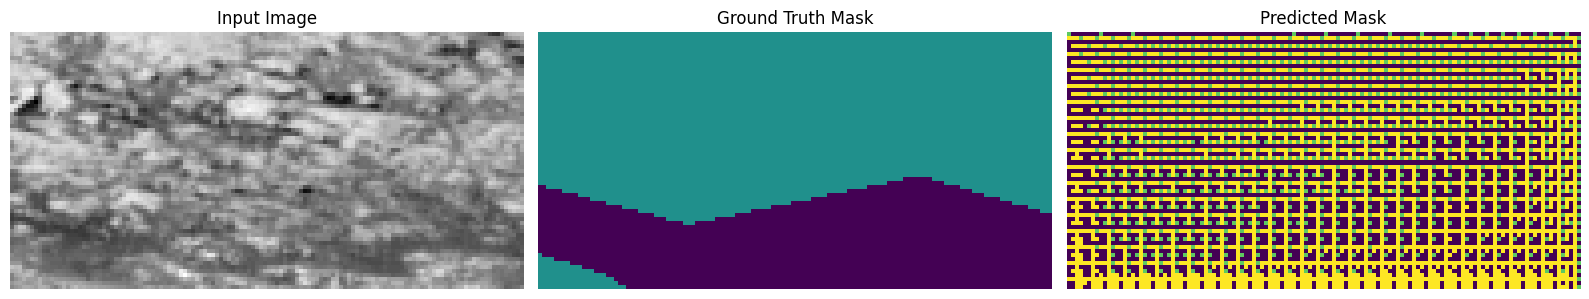

35/35 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.3139 - loss: 1.5225 - mean_iou: 0.1609 - val_accuracy: 0.1505 - val_loss: 15.2585 - val_mean_iou: 0.0243
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 561ms/step - accuracy: 0.4337 - loss: 1.1914 - mean_iou: 0.2444 - val_accuracy: 0.1791 - val_loss: 9.5593 - val_mean_iou: 0.0363
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 554ms/step - accuracy: 0.5198 - loss: 0.9702 - mean_iou: 0.3178 - val_accuracy: 0.1643 - val_loss: 11.5686 - val_mean_iou: 0.0493
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 535ms/step - accuracy: 0.5489 - loss: 0.8465 - mean_iou: 0.3438 - val_accuracy: 0.2242 - val_loss: 10.1171 - val_mean_iou: 0.0184
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 536ms/step - accuracy: 0.5574 - loss: 0.7810 - mean_iou: 0.3542 - val_accuracy: 0.2068 - val_loss: 10.1333 - val_mean_iou: 0.0168
Epoch 6/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.5608 - loss: 0.7545 - mean_iou: 0.3571

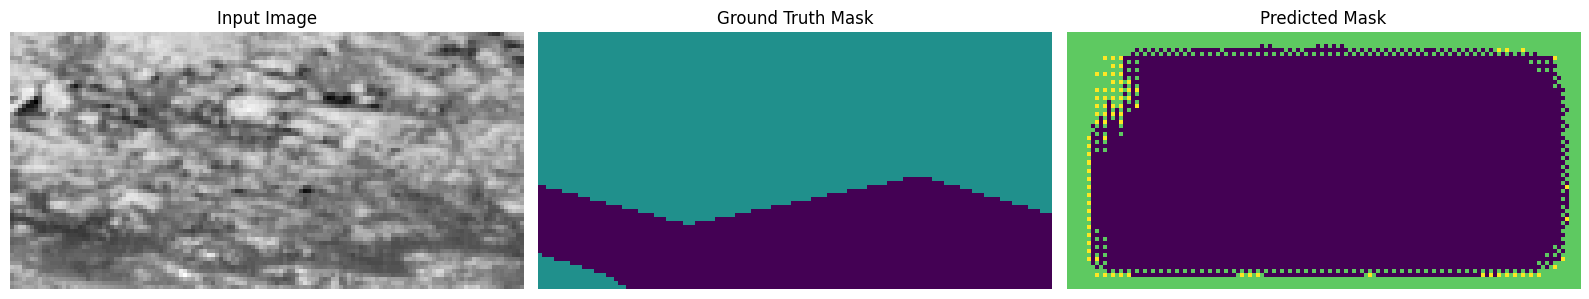

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 555ms/step - accuracy: 0.5611 - loss: 0.7540 - mean_iou: 0.3573 - val_accuracy: 0.2235 - val_loss: 7.4333 - val_mean_iou: 0.0417
Epoch 7/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.5849 - loss: 0.6711 - mean_iou: 0.3841 - val_accuracy: 0.2455 - val_loss: 3.1486 - val_mean_iou: 0.0767
Epoch 8/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.5958 - loss: 0.6421 - mean_iou: 0.3942 - val_accuracy: 0.3315 - val_loss: 2.9614 - val_mean_iou: 0.1650
Epoch 9/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 539ms/step - accuracy: 0.6042 - loss: 0.5998 - mean_iou: 0.4040 - val_accuracy: 0.3412 - val_loss: 2.4308 - val_mean_iou: 0.1378
Epoch 10/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6139 - loss: 0.5653 - mean_iou: 0.4169 - val_accuracy: 0.4621 - val_loss: 1.4183 - val_mean_iou: 0.2736
Epoch 11/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6087 - loss: 0.5749 - mean_iou: 0.4107

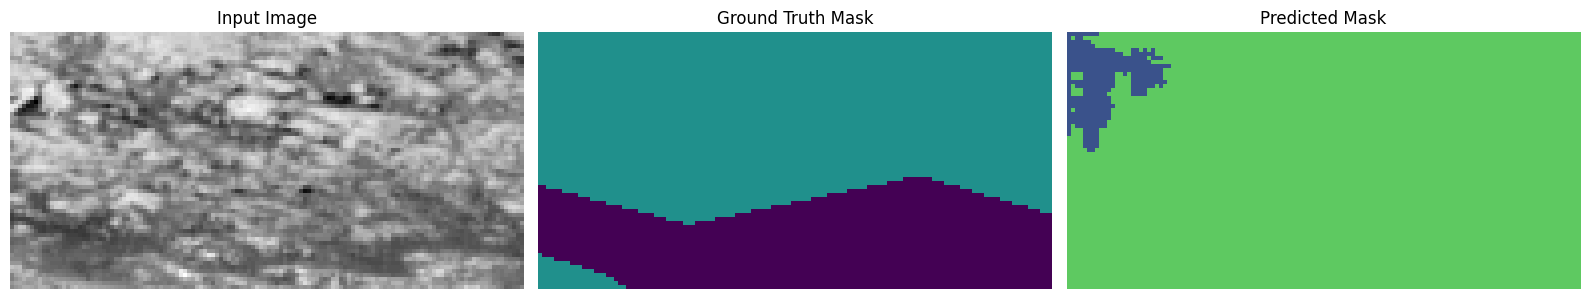

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 551ms/step - accuracy: 0.6086 - loss: 0.5755 - mean_iou: 0.4104 - val_accuracy: 0.3961 - val_loss: 1.4422 - val_mean_iou: 0.2182
Epoch 12/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.6209 - loss: 0.5362 - mean_iou: 0.4256 - val_accuracy: 0.4731 - val_loss: 1.1735 - val_mean_iou: 0.2854
Epoch 13/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.6260 - loss: 0.5217 - mean_iou: 0.4383 - val_accuracy: 0.4458 - val_loss: 1.1445 - val_mean_iou: 0.3072
Epoch 14/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6190 - loss: 0.5334 - mean_iou: 0.4213 - val_accuracy: 0.5243 - val_loss: 0.9330 - val_mean_iou: 0.3595
Epoch 15/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6240 - loss: 0.5012 - mean_iou: 0.4309 - val_accuracy: 0.5780 - val_loss: 0.6550 - val_mean_iou: 0.4449
Epoch 16/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.6239 - loss: 0.5007 - mean_iou: 0.4346

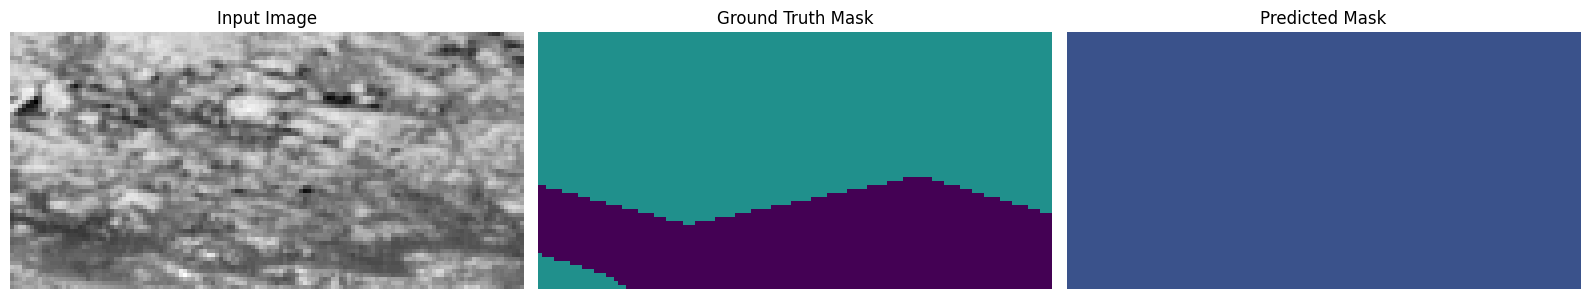

35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 557ms/step - accuracy: 0.6239 - loss: 0.5011 - mean_iou: 0.4343 - val_accuracy: 0.5897 - val_loss: 0.6425 - val_mean_iou: 0.4569
Epoch 17/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.6298 - loss: 0.4956 - mean_iou: 0.4337 - val_accuracy: 0.5724 - val_loss: 0.7370 - val_mean_iou: 0.3608
Epoch 18/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 546ms/step - accuracy: 0.6258 - loss: 0.4987 - mean_iou: 0.4290 - val_accuracy: 0.5831 - val_loss: 0.6493 - val_mean_iou: 0.3657
Epoch 19/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 540ms/step - accuracy: 0.6232 - loss: 0.5022 - mean_iou: 0.4575 - val_accuracy: 0.6469 - val_loss: 0.4526 - val_mean_iou: 0.4363
Epoch 20/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.6375 - loss: 0.4719 - mean_iou: 0.4438 - val_accuracy: 0.5508 - val_loss: 0.7483 - val_mean_iou: 0.3508
Epoch 21/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6393 - loss: 0.4618 - mean_iou: 0.4467

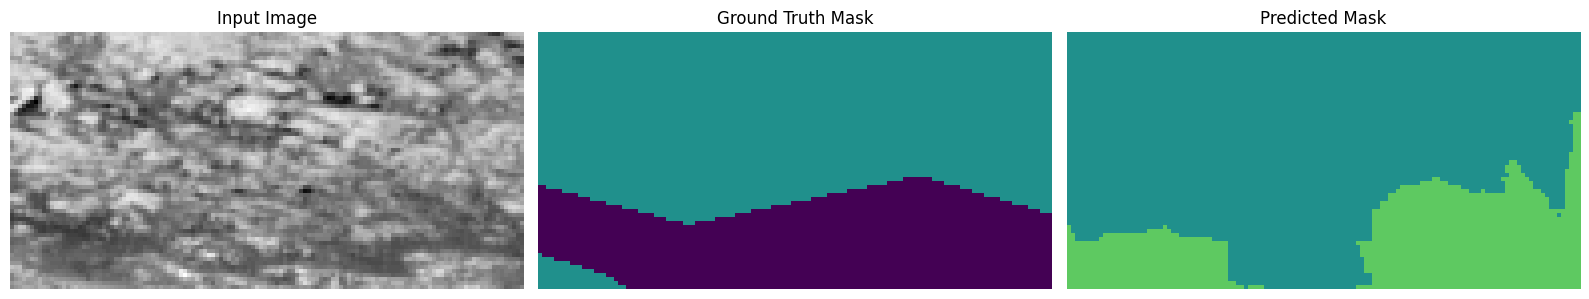

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 552ms/step - accuracy: 0.6395 - loss: 0.4618 - mean_iou: 0.4466 - val_accuracy: 0.6103 - val_loss: 0.5745 - val_mean_iou: 0.4985
Epoch 22/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6322 - loss: 0.4602 - mean_iou: 0.4479 - val_accuracy: 0.6102 - val_loss: 0.5616 - val_mean_iou: 0.4864
Epoch 23/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.6488 - loss: 0.4320 - mean_iou: 0.4631 - val_accuracy: 0.3934 - val_loss: 1.5710 - val_mean_iou: 0.2783
Epoch 24/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.6484 - loss: 0.4410 - mean_iou: 0.4736 - val_accuracy: 0.6232 - val_loss: 0.5246 - val_mean_iou: 0.5129
Epoch 25/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6473 - loss: 0.4332 - mean_iou: 0.4933 - val_accuracy: 0.6615 - val_loss: 0.4015 - val_mean_iou: 0.5750
Epoch 26/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.6540 - loss: 0.4294 - mean_iou: 0.5253

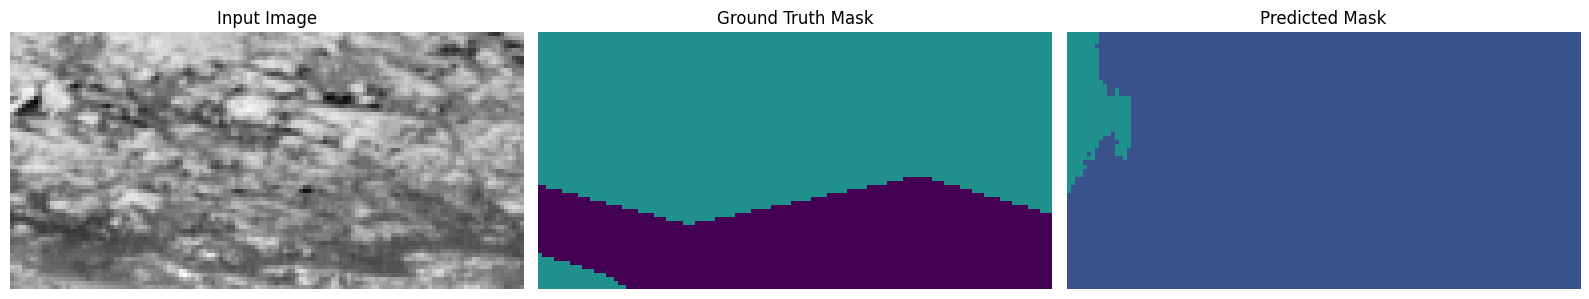

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 554ms/step - accuracy: 0.6541 - loss: 0.4295 - mean_iou: 0.5234 - val_accuracy: 0.6091 - val_loss: 0.5263 - val_mean_iou: 0.4830
Epoch 27/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6552 - loss: 0.4208 - mean_iou: 0.4827 - val_accuracy: 0.4658 - val_loss: 0.9750 - val_mean_iou: 0.3467
Epoch 28/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6396 - loss: 0.4479 - mean_iou: 0.4537 - val_accuracy: 0.6384 - val_loss: 0.4691 - val_mean_iou: 0.5372
Epoch 29/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6509 - loss: 0.4316 - mean_iou: 0.4783 - val_accuracy: 0.6387 - val_loss: 0.4798 - val_mean_iou: 0.4231
Epoch 30/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6593 - loss: 0.4174 - mean_iou: 0.5240 - val_accuracy: 0.6341 - val_loss: 0.4765 - val_mean_iou: 0.5294
Epoch 31/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6580 - loss: 0.4214 - mean_iou: 0.5327

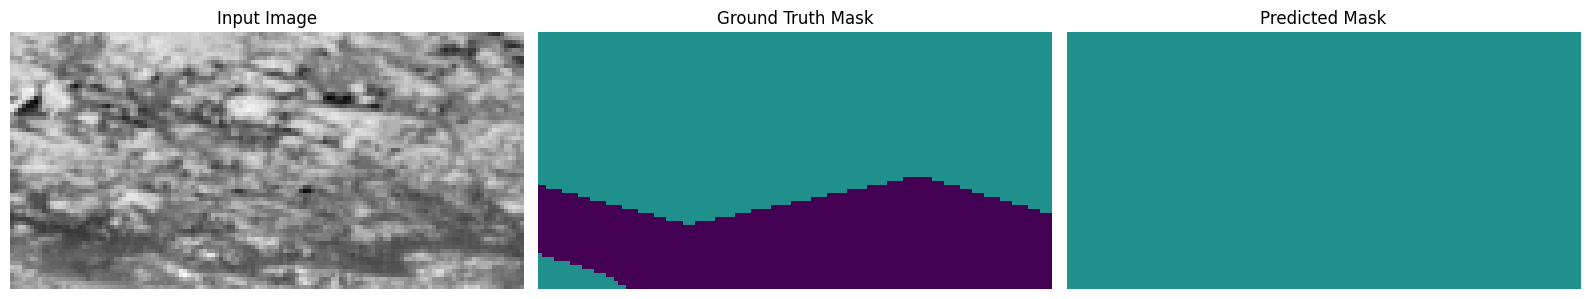

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 548ms/step - accuracy: 0.6580 - loss: 0.4217 - mean_iou: 0.5307 - val_accuracy: 0.5988 - val_loss: 0.5694 - val_mean_iou: 0.4870
Epoch 32/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6535 - loss: 0.4134 - mean_iou: 0.4792 - val_accuracy: 0.6338 - val_loss: 0.4843 - val_mean_iou: 0.5320
Epoch 33/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6455 - loss: 0.4270 - mean_iou: 0.5063 - val_accuracy: 0.6639 - val_loss: 0.4019 - val_mean_iou: 0.5744
Epoch 34/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 548ms/step - accuracy: 0.6401 - loss: 0.4370 - mean_iou: 0.4789 - val_accuracy: 0.6181 - val_loss: 0.5312 - val_mean_iou: 0.3985
Epoch 35/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6586 - loss: 0.4178 - mean_iou: 0.4827 - val_accuracy: 0.6030 - val_loss: 0.5664 - val_mean_iou: 0.4889
Epoch 36/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6484 - loss: 0.4291 - mean_iou: 0.4694

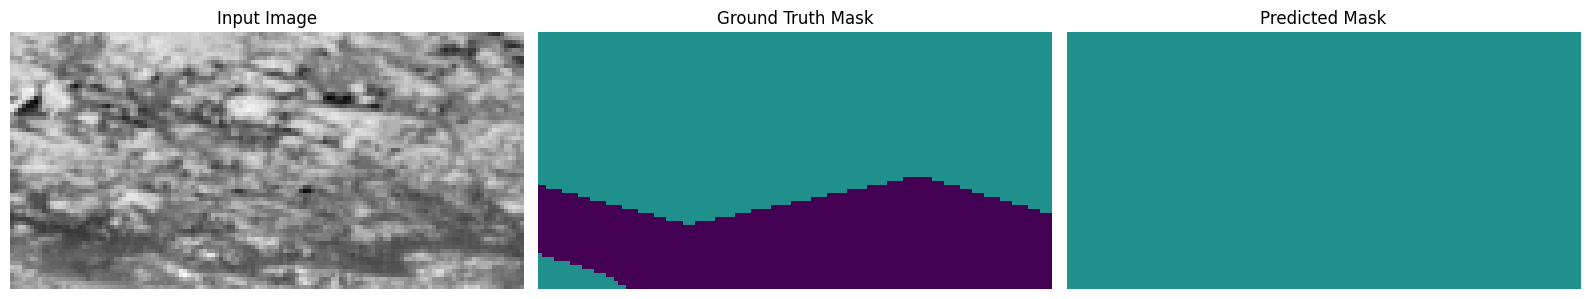

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.6484 - loss: 0.4294 - mean_iou: 0.4691 - val_accuracy: 0.6564 - val_loss: 0.4210 - val_mean_iou: 0.4541
Epoch 37/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6549 - loss: 0.4163 - mean_iou: 0.4666 - val_accuracy: 0.6521 - val_loss: 0.4183 - val_mean_iou: 0.4438
Epoch 38/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 540ms/step - accuracy: 0.6540 - loss: 0.4120 - mean_iou: 0.5476 - val_accuracy: 0.6526 - val_loss: 0.4231 - val_mean_iou: 0.5589
Epoch 39/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6609 - loss: 0.4008 - mean_iou: 0.4978 - val_accuracy: 0.6417 - val_loss: 0.4308 - val_mean_iou: 0.5493
Epoch 40/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6559 - loss: 0.4047 - mean_iou: 0.5881 - val_accuracy: 0.6481 - val_loss: 0.4213 - val_mean_iou: 0.4408
Epoch 41/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6647 - loss: 0.3969 - mean_iou: 0.5146

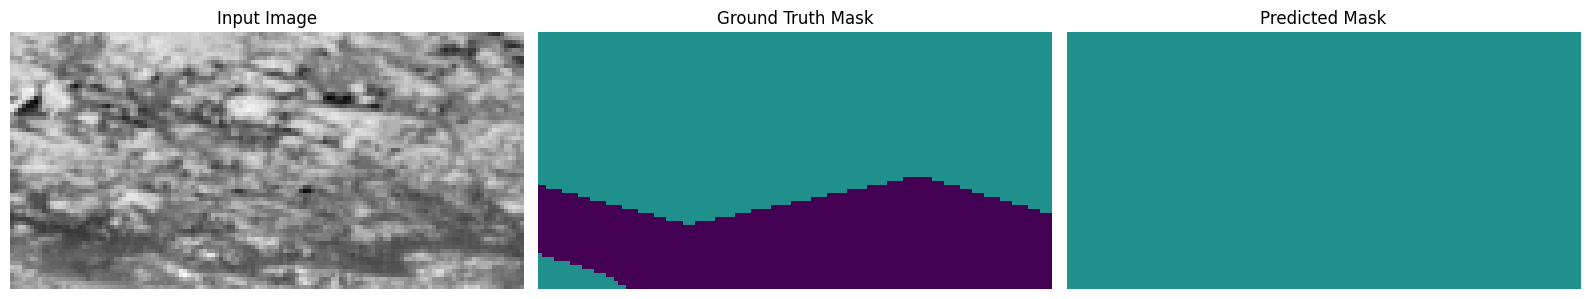

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 548ms/step - accuracy: 0.6647 - loss: 0.3972 - mean_iou: 0.5135 - val_accuracy: 0.6289 - val_loss: 0.4571 - val_mean_iou: 0.5329
Epoch 42/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 539ms/step - accuracy: 0.6568 - loss: 0.4027 - mean_iou: 0.5647 - val_accuracy: 0.6163 - val_loss: 0.4998 - val_mean_iou: 0.5176
Epoch 43/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6626 - loss: 0.3947 - mean_iou: 0.4826 - val_accuracy: 0.6657 - val_loss: 0.3739 - val_mean_iou: 0.5789
Epoch 44/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6620 - loss: 0.3955 - mean_iou: 0.4805 - val_accuracy: 0.6461 - val_loss: 0.4412 - val_mean_iou: 0.5530
Epoch 45/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6627 - loss: 0.4001 - mean_iou: 0.4890 - val_accuracy: 0.5134 - val_loss: 0.8793 - val_mean_iou: 0.4082
Epoch 46/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.6513 - loss: 0.4163 - mean_iou: 0.4752

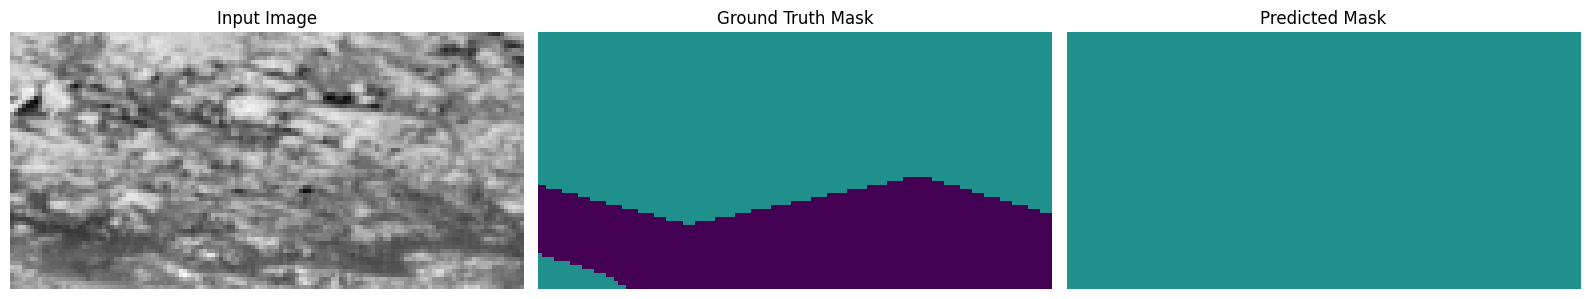

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 555ms/step - accuracy: 0.6516 - loss: 0.4162 - mean_iou: 0.4750 - val_accuracy: 0.6425 - val_loss: 0.4304 - val_mean_iou: 0.5527
Epoch 47/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6687 - loss: 0.3863 - mean_iou: 0.6031 - val_accuracy: 0.6685 - val_loss: 0.3699 - val_mean_iou: 0.5822
Epoch 48/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 540ms/step - accuracy: 0.6601 - loss: 0.3980 - mean_iou: 0.5111 - val_accuracy: 0.6597 - val_loss: 0.4367 - val_mean_iou: 0.5733
Epoch 49/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.6708 - loss: 0.3758 - mean_iou: 0.6083 - val_accuracy: 0.6667 - val_loss: 0.3951 - val_mean_iou: 0.5815
Epoch 50/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.6625 - loss: 0.3898 - mean_iou: 0.5973 - val_accuracy: 0.6064 - val_loss: 0.5495 - val_mean_iou: 0.5006
Epoch 51/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6692 - loss: 0.3776 - mean_iou: 0.6105

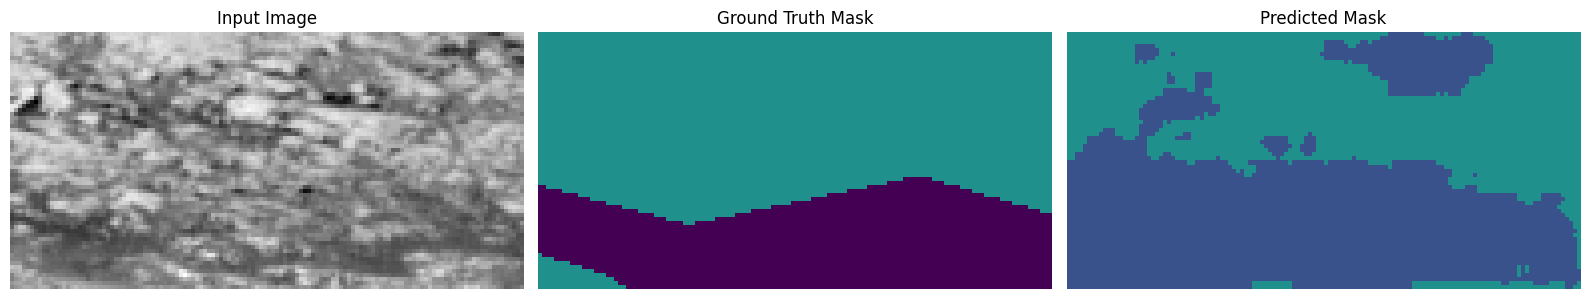

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 549ms/step - accuracy: 0.6694 - loss: 0.3776 - mean_iou: 0.6104 - val_accuracy: 0.6324 - val_loss: 0.4905 - val_mean_iou: 0.5247
Epoch 52/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.6640 - loss: 0.3799 - mean_iou: 0.5211 - val_accuracy: 0.6692 - val_loss: 0.3984 - val_mean_iou: 0.5850
Epoch 53/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6644 - loss: 0.3856 - mean_iou: 0.5479 - val_accuracy: 0.6522 - val_loss: 0.4389 - val_mean_iou: 0.5564
Epoch 54/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.6692 - loss: 0.3674 - mean_iou: 0.4988 - val_accuracy: 0.6034 - val_loss: 0.5730 - val_mean_iou: 0.4948
Epoch 55/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 539ms/step - accuracy: 0.6613 - loss: 0.3872 - mean_iou: 0.4834 - val_accuracy: 0.6610 - val_loss: 0.3829 - val_mean_iou: 0.5787
Epoch 56/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.6713 - loss: 0.3649 - mean_iou: 0.6096

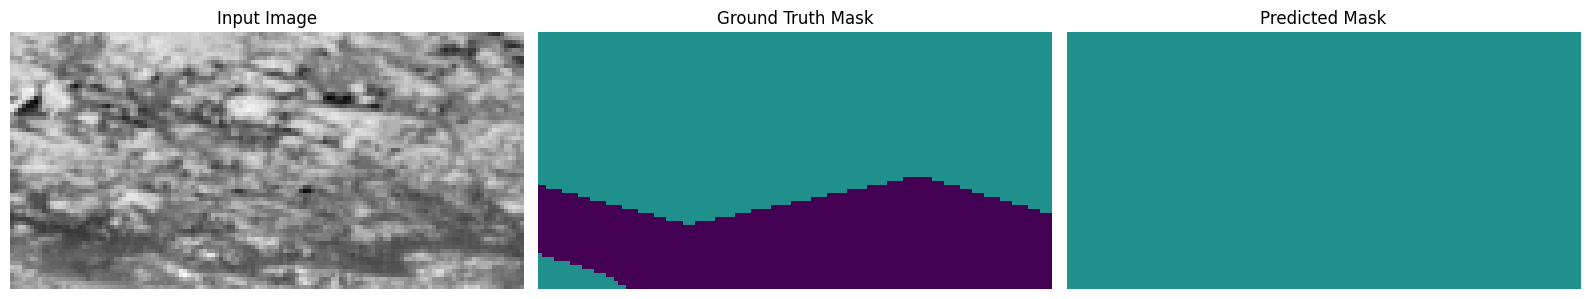

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 552ms/step - accuracy: 0.6714 - loss: 0.3651 - mean_iou: 0.6094 - val_accuracy: 0.6500 - val_loss: 0.4293 - val_mean_iou: 0.5637
Epoch 57/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6733 - loss: 0.3729 - mean_iou: 0.6113 - val_accuracy: 0.6176 - val_loss: 0.5073 - val_mean_iou: 0.5171
Epoch 58/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6704 - loss: 0.3685 - mean_iou: 0.5860 - val_accuracy: 0.6620 - val_loss: 0.3966 - val_mean_iou: 0.5769
Epoch 59/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 537ms/step - accuracy: 0.6720 - loss: 0.3638 - mean_iou: 0.6238 - val_accuracy: 0.6588 - val_loss: 0.3998 - val_mean_iou: 0.5684
Epoch 60/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6748 - loss: 0.3583 - mean_iou: 0.5109 - val_accuracy: 0.6243 - val_loss: 0.5234 - val_mean_iou: 0.5204
Epoch 61/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.6712 - loss: 0.3811 - mean_iou: 0.4981

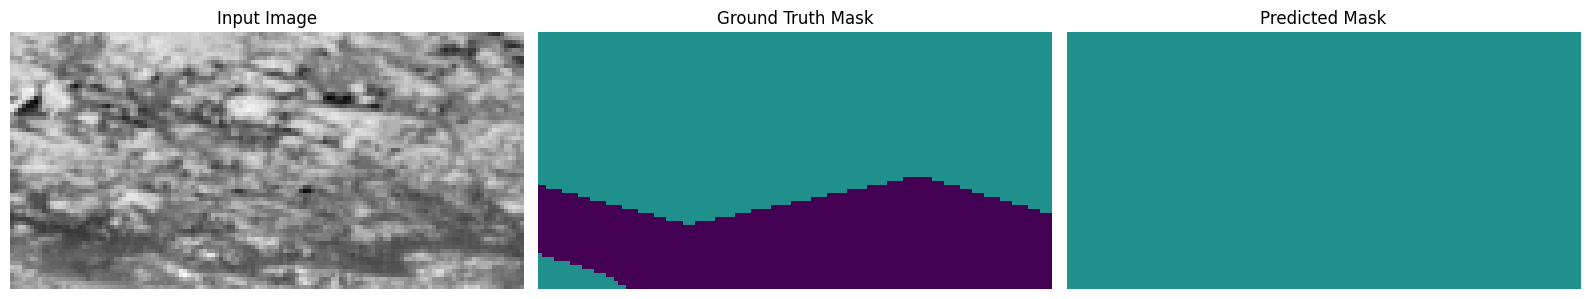

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 552ms/step - accuracy: 0.6712 - loss: 0.3814 - mean_iou: 0.4975 - val_accuracy: 0.6590 - val_loss: 0.4134 - val_mean_iou: 0.5715
Epoch 62/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6626 - loss: 0.3886 - mean_iou: 0.6012 - val_accuracy: 0.3991 - val_loss: 1.2138 - val_mean_iou: 0.2933
Epoch 63/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6688 - loss: 0.3701 - mean_iou: 0.6208 - val_accuracy: 0.6631 - val_loss: 0.4130 - val_mean_iou: 0.5760
Epoch 64/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6784 - loss: 0.3574 - mean_iou: 0.5616 - val_accuracy: 0.6664 - val_loss: 0.3828 - val_mean_iou: 0.5803
Epoch 65/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6743 - loss: 0.3641 - mean_iou: 0.6089 - val_accuracy: 0.6524 - val_loss: 0.4160 - val_mean_iou: 0.5560
Epoch 66/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.6798 - loss: 0.3561 - mean_iou: 0.5500

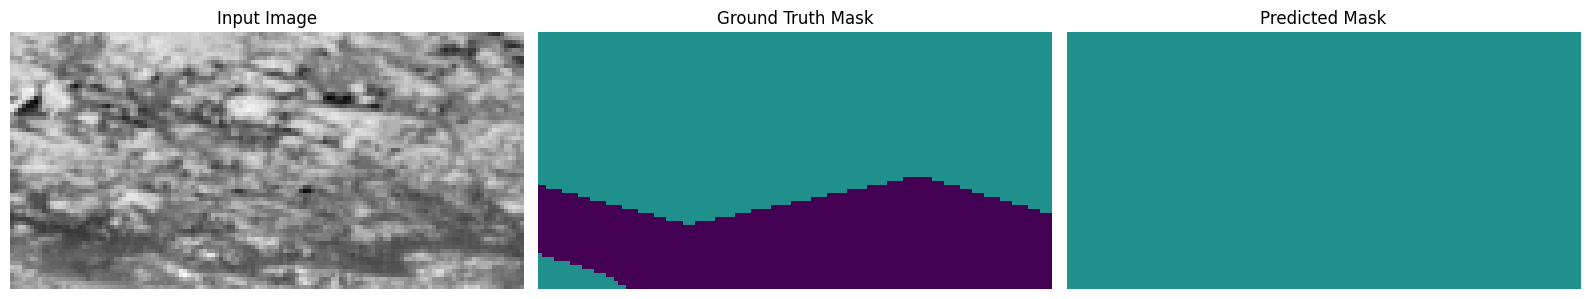

35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 575ms/step - accuracy: 0.6799 - loss: 0.3564 - mean_iou: 0.5486 - val_accuracy: 0.6842 - val_loss: 0.3663 - val_mean_iou: 0.6090
Epoch 67/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6730 - loss: 0.3628 - mean_iou: 0.5677 - val_accuracy: 0.6764 - val_loss: 0.3690 - val_mean_iou: 0.5923
Epoch 68/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6759 - loss: 0.3598 - mean_iou: 0.5349 - val_accuracy: 0.6745 - val_loss: 0.3888 - val_mean_iou: 0.5926
Epoch 69/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6806 - loss: 0.3453 - mean_iou: 0.6169 - val_accuracy: 0.6690 - val_loss: 0.3913 - val_mean_iou: 0.5875
Epoch 70/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6747 - loss: 0.3588 - mean_iou: 0.5019 - val_accuracy: 0.6678 - val_loss: 0.3959 - val_mean_iou: 0.5810
Epoch 71/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6800 - loss: 0.3513 - mean_iou: 0.6240

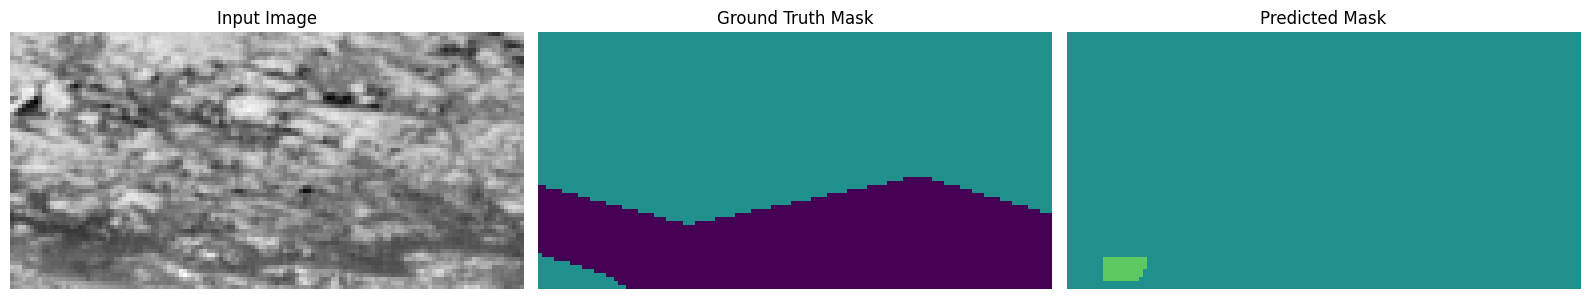

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 551ms/step - accuracy: 0.6801 - loss: 0.3515 - mean_iou: 0.6205 - val_accuracy: 0.6713 - val_loss: 0.4005 - val_mean_iou: 0.5944
Epoch 72/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 546ms/step - accuracy: 0.6751 - loss: 0.3546 - mean_iou: 0.6215 - val_accuracy: 0.6837 - val_loss: 0.3601 - val_mean_iou: 0.6093
Epoch 73/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6760 - loss: 0.3508 - mean_iou: 0.5937 - val_accuracy: 0.6764 - val_loss: 0.3673 - val_mean_iou: 0.5970
Epoch 74/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6741 - loss: 0.3545 - mean_iou: 0.5643 - val_accuracy: 0.6614 - val_loss: 0.4104 - val_mean_iou: 0.5751
Epoch 75/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 546ms/step - accuracy: 0.6756 - loss: 0.3572 - mean_iou: 0.5584 - val_accuracy: 0.6779 - val_loss: 0.3790 - val_mean_iou: 0.5958
Epoch 76/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6839 - loss: 0.3423 - mean_iou: 0.5190

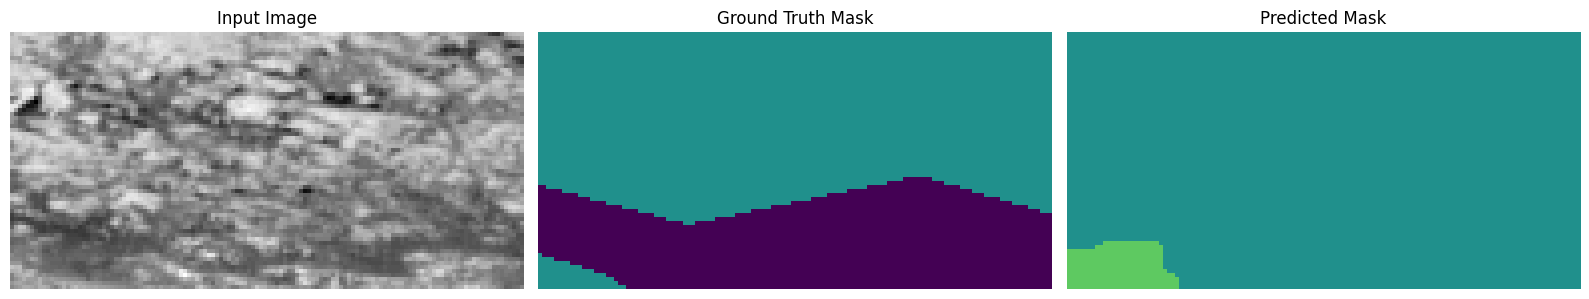

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 548ms/step - accuracy: 0.6840 - loss: 0.3424 - mean_iou: 0.5186 - val_accuracy: 0.5725 - val_loss: 0.6318 - val_mean_iou: 0.4668
Epoch 77/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6828 - loss: 0.3374 - mean_iou: 0.6515 - val_accuracy: 0.6731 - val_loss: 0.3650 - val_mean_iou: 0.5901
Epoch 78/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6770 - loss: 0.3446 - mean_iou: 0.5852 - val_accuracy: 0.5350 - val_loss: 0.7404 - val_mean_iou: 0.4247
Epoch 79/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6887 - loss: 0.3289 - mean_iou: 0.5163 - val_accuracy: 0.6613 - val_loss: 0.4031 - val_mean_iou: 0.5733
Epoch 80/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6771 - loss: 0.3562 - mean_iou: 0.5419 - val_accuracy: 0.6173 - val_loss: 0.5108 - val_mean_iou: 0.5223
Epoch 81/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6848 - loss: 0.3377 - mean_iou: 0.6572

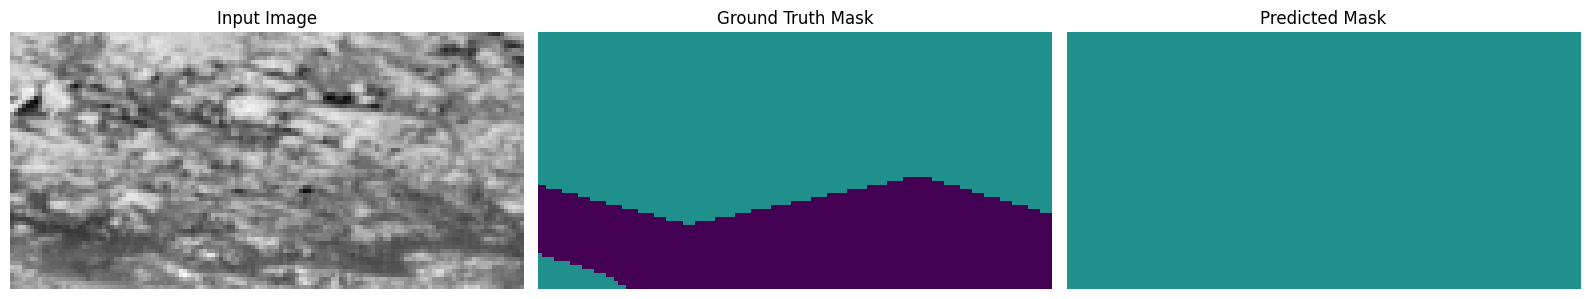

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 551ms/step - accuracy: 0.6849 - loss: 0.3379 - mean_iou: 0.6567 - val_accuracy: 0.6743 - val_loss: 0.3617 - val_mean_iou: 0.5894
Epoch 82/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6899 - loss: 0.3264 - mean_iou: 0.5687 - val_accuracy: 0.6812 - val_loss: 0.3726 - val_mean_iou: 0.6058
Epoch 83/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6765 - loss: 0.3430 - mean_iou: 0.6184 - val_accuracy: 0.6739 - val_loss: 0.3774 - val_mean_iou: 0.5959
Epoch 84/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 546ms/step - accuracy: 0.6877 - loss: 0.3331 - mean_iou: 0.5476 - val_accuracy: 0.6891 - val_loss: 0.3428 - val_mean_iou: 0.6184
Epoch 85/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 539ms/step - accuracy: 0.6765 - loss: 0.3421 - mean_iou: 0.6648 - val_accuracy: 0.6622 - val_loss: 0.3912 - val_mean_iou: 0.5793
Epoch 86/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.6881 - loss: 0.3315 - mean_iou: 0.6420

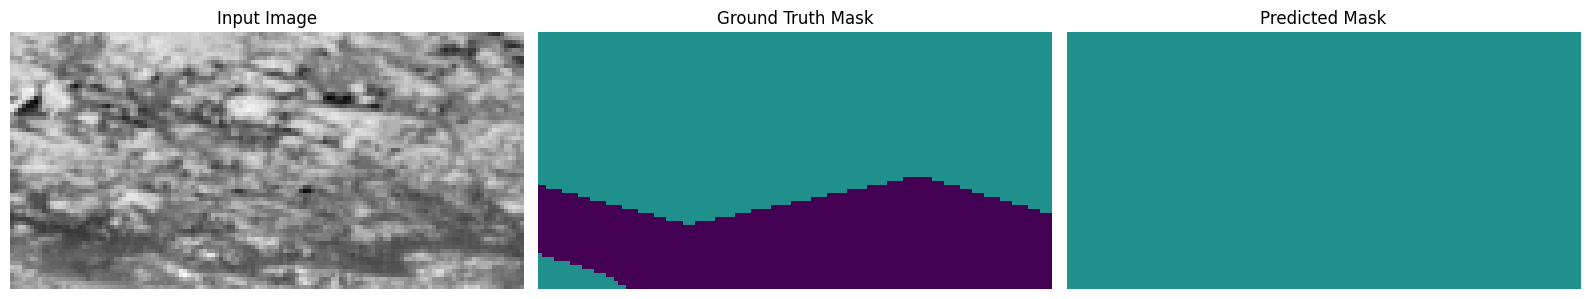

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 549ms/step - accuracy: 0.6883 - loss: 0.3316 - mean_iou: 0.6387 - val_accuracy: 0.6699 - val_loss: 0.3867 - val_mean_iou: 0.5904
Epoch 87/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6842 - loss: 0.3408 - mean_iou: 0.6436 - val_accuracy: 0.6662 - val_loss: 0.3929 - val_mean_iou: 0.5854
Epoch 88/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 540ms/step - accuracy: 0.6825 - loss: 0.3481 - mean_iou: 0.5156 - val_accuracy: 0.6648 - val_loss: 0.4119 - val_mean_iou: 0.4619
Epoch 89/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6846 - loss: 0.3361 - mean_iou: 0.5418 - val_accuracy: 0.6577 - val_loss: 0.4398 - val_mean_iou: 0.5711
Epoch 90/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6882 - loss: 0.3340 - mean_iou: 0.5744 - val_accuracy: 0.6678 - val_loss: 0.3858 - val_mean_iou: 0.5837
Epoch 91/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6872 - loss: 0.3409 - mean_iou: 0.5999

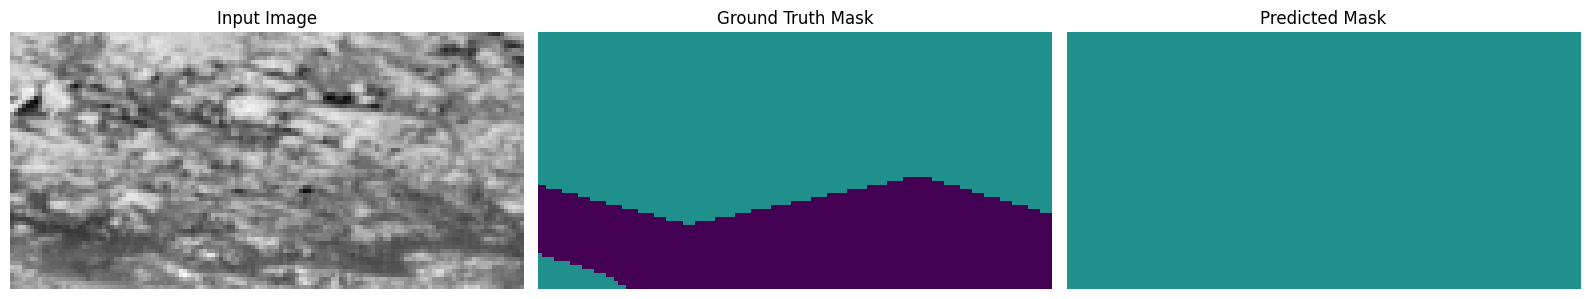

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 553ms/step - accuracy: 0.6874 - loss: 0.3407 - mean_iou: 0.5980 - val_accuracy: 0.6703 - val_loss: 0.3768 - val_mean_iou: 0.5863
Epoch 92/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6826 - loss: 0.3458 - mean_iou: 0.6084 - val_accuracy: 0.6841 - val_loss: 0.3333 - val_mean_iou: 0.4882
Epoch 93/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6845 - loss: 0.3345 - mean_iou: 0.6076 - val_accuracy: 0.6769 - val_loss: 0.3971 - val_mean_iou: 0.5996
Epoch 94/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6890 - loss: 0.3225 - mean_iou: 0.6562 - val_accuracy: 0.6862 - val_loss: 0.3650 - val_mean_iou: 0.6148
Epoch 95/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6829 - loss: 0.3415 - mean_iou: 0.6406 - val_accuracy: 0.6706 - val_loss: 0.4323 - val_mean_iou: 0.5876
Epoch 96/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6912 - loss: 0.3237 - mean_iou: 0.6686

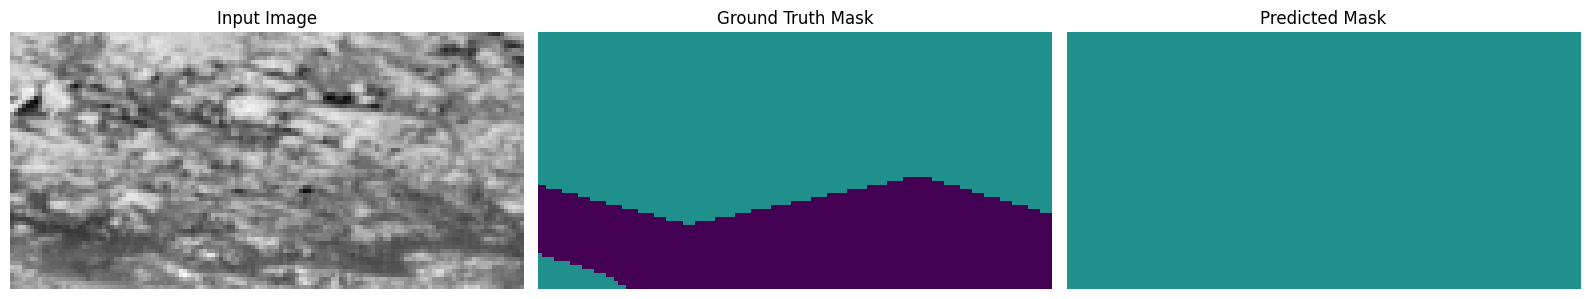

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 554ms/step - accuracy: 0.6913 - loss: 0.3238 - mean_iou: 0.6683 - val_accuracy: 0.6846 - val_loss: 0.3727 - val_mean_iou: 0.6096
Epoch 97/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6904 - loss: 0.3266 - mean_iou: 0.5423 - val_accuracy: 0.6775 - val_loss: 0.3636 - val_mean_iou: 0.6015
Epoch 98/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - accuracy: 0.6892 - loss: 0.3241 - mean_iou: 0.5408 - val_accuracy: 0.6061 - val_loss: 0.5649 - val_mean_iou: 0.5045
Epoch 99/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 549ms/step - accuracy: 0.6909 - loss: 0.3259 - mean_iou: 0.6708 - val_accuracy: 0.6825 - val_loss: 0.3440 - val_mean_iou: 0.6089
Epoch 100/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6970 - loss: 0.3132 - mean_iou: 0.6863 - val_accuracy: 0.6817 - val_loss: 0.3580 - val_mean_iou: 0.6054
Epoch 101/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6906 - loss: 0.3196 - mean_iou: 0.5810

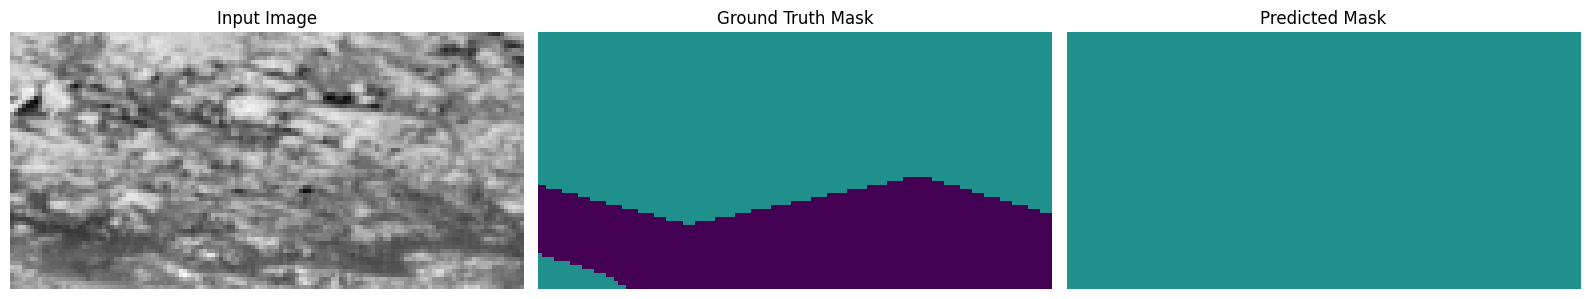

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 551ms/step - accuracy: 0.6909 - loss: 0.3199 - mean_iou: 0.5796 - val_accuracy: 0.6804 - val_loss: 0.3749 - val_mean_iou: 0.6015
Epoch 102/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 540ms/step - accuracy: 0.6845 - loss: 0.3329 - mean_iou: 0.6561 - val_accuracy: 0.6012 - val_loss: 0.5779 - val_mean_iou: 0.5082
Epoch 103/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.6839 - loss: 0.3280 - mean_iou: 0.7006 - val_accuracy: 0.6342 - val_loss: 0.4656 - val_mean_iou: 0.5461
Epoch 104/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6825 - loss: 0.3332 - mean_iou: 0.6263 - val_accuracy: 0.5305 - val_loss: 0.8044 - val_mean_iou: 0.4246
Epoch 105/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6895 - loss: 0.3204 - mean_iou: 0.6712 - val_accuracy: 0.6773 - val_loss: 0.3827 - val_mean_iou: 0.6006
Epoch 106/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6904 - loss: 0.3240 - mean_iou: 0.6352

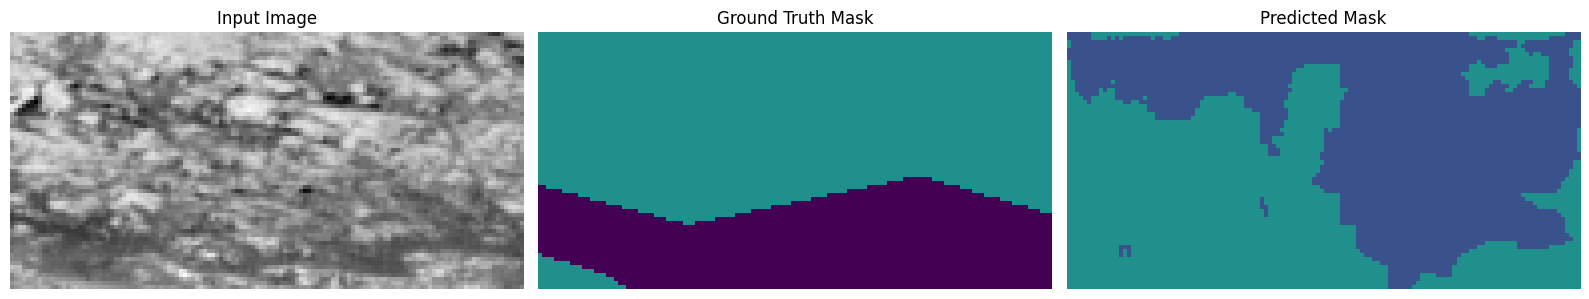

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 550ms/step - accuracy: 0.6906 - loss: 0.3241 - mean_iou: 0.6326 - val_accuracy: 0.6602 - val_loss: 0.4060 - val_mean_iou: 0.5674
Epoch 107/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6861 - loss: 0.3250 - mean_iou: 0.6009 - val_accuracy: 0.6878 - val_loss: 0.3296 - val_mean_iou: 0.6170
Epoch 108/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6933 - loss: 0.3157 - mean_iou: 0.6949 - val_accuracy: 0.6205 - val_loss: 0.5042 - val_mean_iou: 0.5261
Epoch 109/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.6860 - loss: 0.3308 - mean_iou: 0.6569 - val_accuracy: 0.6787 - val_loss: 0.3536 - val_mean_iou: 0.6049
Epoch 110/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 540ms/step - accuracy: 0.6921 - loss: 0.3143 - mean_iou: 0.6087 - val_accuracy: 0.6792 - val_loss: 0.3680 - val_mean_iou: 0.6055
Epoch 111/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.6871 - loss: 0.3209 - mean_iou: 0.6024

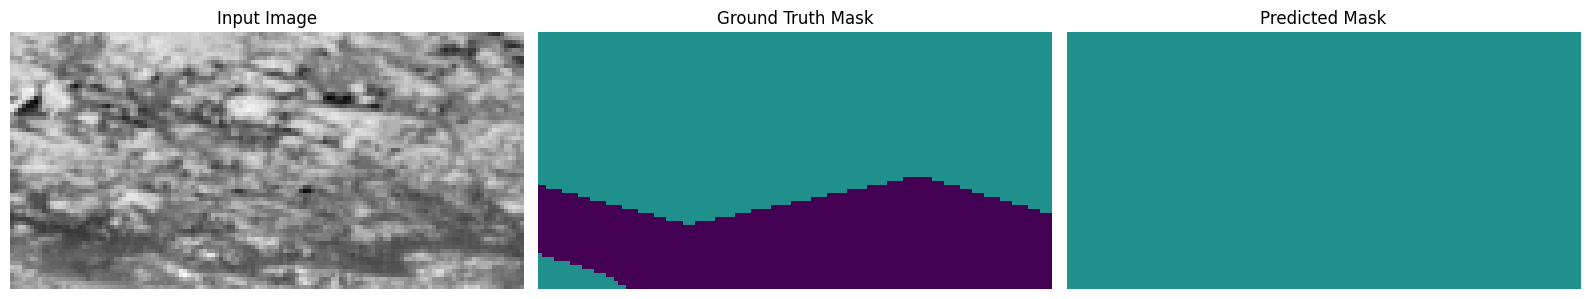

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 553ms/step - accuracy: 0.6873 - loss: 0.3211 - mean_iou: 0.6003 - val_accuracy: 0.6865 - val_loss: 0.3544 - val_mean_iou: 0.6137
Epoch 112/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.6930 - loss: 0.3214 - mean_iou: 0.5809 - val_accuracy: 0.6829 - val_loss: 0.3661 - val_mean_iou: 0.6080
Epoch 113/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.7007 - loss: 0.3108 - mean_iou: 0.6763 - val_accuracy: 0.6750 - val_loss: 0.3771 - val_mean_iou: 0.5975
Epoch 114/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 539ms/step - accuracy: 0.6937 - loss: 0.3170 - mean_iou: 0.6217 - val_accuracy: 0.6896 - val_loss: 0.3489 - val_mean_iou: 0.6182
Final validation Mean Intersection Over Union: 61.84%


In [17]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

In [18]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_MultiResNet_{timestep_str}_{str(final_val_meanIoU)}.keras"
model.save(model_filename)


In [19]:
del model

print(f"Model saved to {model_filename}")

Model saved to model_MultiResNet_241213_192451_61.84.keras


## Results

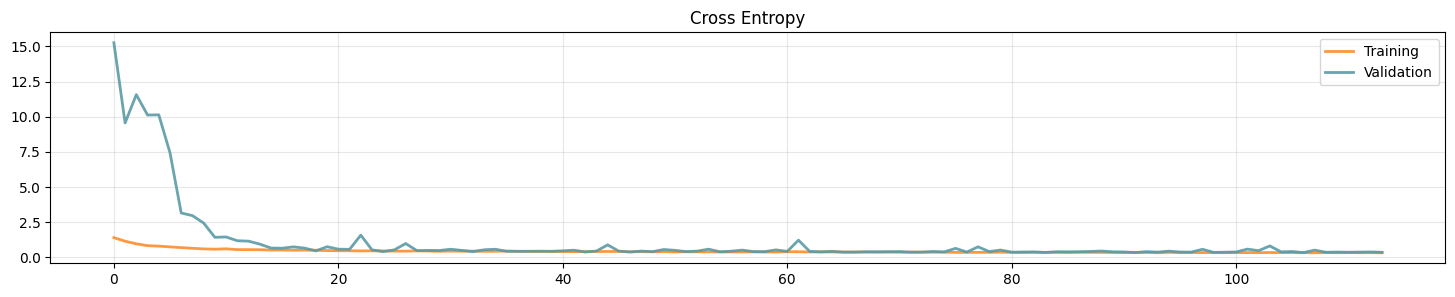

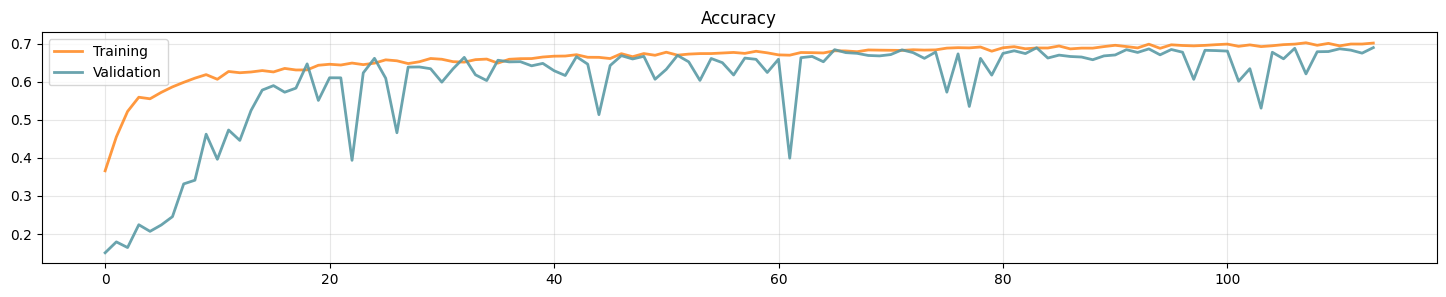

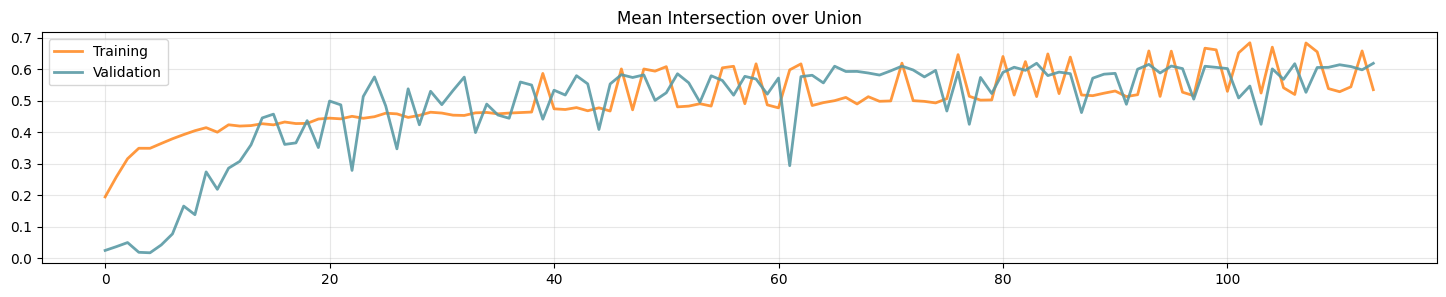

In [20]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [21]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [22]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_MultiResNet_241213_192451_61.84.keras


In [23]:
preds = model.predict(X_test)
predicted_classes = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes

preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")


314/314 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step
Predictions shape: (10022, 64, 128, 5)
Predictions shape: (10022, 64, 128)


In [25]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [26]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

#from google.colab import files
#files.download(submission_filename)

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```

In [ ]:
import time
import numpy as np
import sounddevice as sd

def generate_noise(duration=1, sample_rate=44100):
    """Génère un bruit blanc de la durée spécifiée."""
    samples = np.random.uniform(-1, 1, size=(duration * sample_rate,))
    return samples

# Paramètres
sample_rate = 44100  # Fréquence d'échantillonnage en Hz

try:
    print("Le bruit infini est en cours... Interrompez l'exécution pour arrêter.")
    while True:
        noise = generate_noise(duration=1, sample_rate=sample_rate)
        sd.play(noise, samplerate=sample_rate)
        time.sleep(1)  # Attendre la fin de chaque segment avant de continuer
except KeyboardInterrupt:
    print("Exécution interrompue.")
    sd.stop()
